# **Fashion MNIST: Classification of Items Based on Their Images**

---
**developed by: Uday Santhosh Raju Vysyaraju, Sejeong Moon, Rucha Ravindra Gole **


In [ ]:
## IF running on collab - run below CELL, else start from imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### 1. Import Libraries

In [2]:
!pip install scikit-learn
!pip install seaborn
!pip install pandas
!pip install torch
!pip install torchvision
!pip install torcheval

!pip install -r requirements.txt

^C


In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

import torch.optim as optim
from torch.utils.data import random_split

import time
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torcheval.metrics.functional import multiclass_f1_score

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.2/99.8 MB 3.6 MB/s eta 0:00:28
   ---------------------------------------- 0.5/99.8 MB 4.5 MB/s eta 0:00:23
   ---------------------------------------- 0.9/99.8 MB 5.5 MB/s eta 0:00:18
   ---------------------------------------- 1.2/99.8 MB 5.4 MB/s eta 0:00:19
    --------------------------------------- 1.4/99.8 MB 5.4 MB/s eta 0:00:19
    --------------------------------------- 1.8/99.8 MB 5.8 MB/s eta 0:00:17
    --------------------------------------- 2.2/99.8 MB 6.1 MB/s eta 0:00:17
   - -------------------------------------- 2.5/99.8 MB 6.4 MB/s eta 0:00:16
   - -------------------------------------- 3.0/99.8 MB 6.8 MB/s eta 0:00:15
   - -------------------------------------- 3.4/99.8 MB 6.8 MB/s eta 0:00:15
   - -------------------------------------- 3.6/99.8 MB 6.5 MB/s eta 0:00:15
   - -

#### 2. Load Data - Torch and Data Preparation


- The Data is already split into train and test images and labels.  <br>
- Next step is to perform validation split- which will be performed in model development phase.


In [9]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))


# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


100.0%


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100.0%

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



#### 3. Data Analysis and EDA

In [10]:
# images and labels
train_images = train_set.data
train_labels = train_set.targets

test_images = test_set.data
test_labels = test_set.targets

In [11]:
print("Each Training Image Size", train_images[0].shape)
print("Max Training Image Value", train_images[0].max())
print("Max Training Image Value", train_images[0].min())

Each Training Image Size torch.Size([28, 28])
Max Training Image Value tensor(255, dtype=torch.uint8)
Max Training Image Value tensor(0, dtype=torch.uint8)


Text(0.5, 1.0, 'Heatmap of an image')

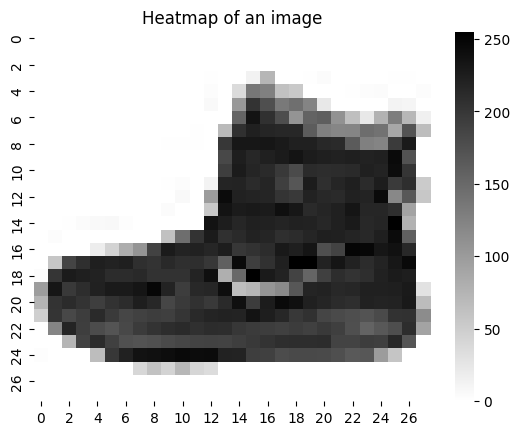

In [12]:
ax = sns.heatmap(train_images[0], annot=False,cmap=plt.cm.binary)
plt.title("Heatmap of an image")

In [13]:
def view_data_info():
    """ Print Information on the Fashion MNIST dataset. """

    print("Data Statistics:")

    # Dataset Information
    print("a. Training Data -> Images Shape: {}, Labels Shape: {}\n".format(
        train_images.shape, train_labels.shape))
    print("b. Test Data -> Images Shape: {}, Labels Shape: {}".format(
        test_images.shape, test_labels.shape))

    ### check classes distribution in Training and Test Data
    class_labels_dict = {value: class_ for class_, value in zip(class_names, list(range(0, len(class_names))))}

    print("\nTrain Data Distribution:")
    train_class_labels = [class_labels_dict[val] for val in np.array(train_labels)]
    cnt = dict(Counter(train_class_labels))
    cnt = pd.DataFrame(cnt, index = ['samples_count_each_class']).T

    print(cnt)
    sns.barplot(cnt.T)
    plt.xticks(rotation= 45);
    plt.title("Train Data Distribution")
    print("\n")
    plt.show()

    print("\nTest Data Distribution:")
    test_class_labels = [class_labels_dict[val] for val in np.array(test_labels)]
    cnt = dict(Counter(test_class_labels))
    cnt = pd.DataFrame(cnt, index = ['samples_count_each_class']).T

    print(cnt)
    sns.barplot(cnt.T)
    plt.xticks(rotation= 45);
    plt.title("Test Data Distribution")
    plt.show()

    print("\n")
    print("\nRandom 15 Images from the Training Data:")
    plt.figure(figsize=(10, 5))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        rand_image_idx = np.random.randint(0, train_labels.shape[0])
        plt.xticks([])
        plt.yticks([])
        # visualize in black and white
        plt.imshow(train_images[rand_image_idx], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[rand_image_idx]])
    plt.show()

    print("\n")
    print("\nRandom 10 Images from the Testing Data:")
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        rand_image_idx = np.random.randint(0, test_labels.shape[0])
        plt.xticks([])
        plt.yticks([])
        # visualize in black and white
        plt.imshow(test_images[rand_image_idx], cmap=plt.cm.binary)
        plt.xlabel(class_names[test_labels[rand_image_idx]])
    plt.show()

def get_pca_result(train_data_input):
  from sklearn.decomposition import PCA

  fig = plt.figure(1, figsize=(8, 6))
  ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

  pca = PCA(n_components=3, random_state=0)
  X_reduced = pca.fit_transform(train_data_input)
  ax.scatter(
      X_reduced[:, 0],
      X_reduced[:, 1],
      X_reduced[:, 2],
      c=train_labels,
      cmap=plt.cm.Set1,
      edgecolor="k",
      s=40,
  )
  ax.set_title("First three PCA components")
  ax.set_xlabel("1st Principal Component")
  ax.xaxis.set_ticklabels([])
  ax.set_ylabel("2nd Principal Component")
  ax.yaxis.set_ticklabels([])
  ax.set_zlabel("3rd Principal Component")
  ax.zaxis.set_ticklabels([])
  plt.show()


  #Print total explain variance ratio for each dimension
  print()
  print('Explained Variance Ratio: ' ,pca.explained_variance_ratio_)
  print("Total Explained Variance:", round(sum(pca.explained_variance_ratio_)*100,4), "%")

def get_best_first_ncomponents(input_data, variance_threshold = 0.95):
  from sklearn.decomposition import PCA
  pca_dims = PCA()
  pca_dims.fit(input_data)
  cumsum = np.cumsum(pca_dims.explained_variance_ratio_)

  top_components_size = np.argmax(cumsum >= variance_threshold) + 1

  return top_components_size




Data Statistics:
a. Training Data -> Images Shape: torch.Size([60000, 28, 28]), Labels Shape: torch.Size([60000])

b. Test Data -> Images Shape: torch.Size([10000, 28, 28]), Labels Shape: torch.Size([10000])

Train Data Distribution:
             samples_count_each_class
Ankle boot                       6000
T-shirt/top                      6000
Dress                            6000
Pullover                         6000
Sneaker                          6000
Sandal                           6000
Trouser                          6000
Shirt                            6000
Coat                             6000
Bag                              6000




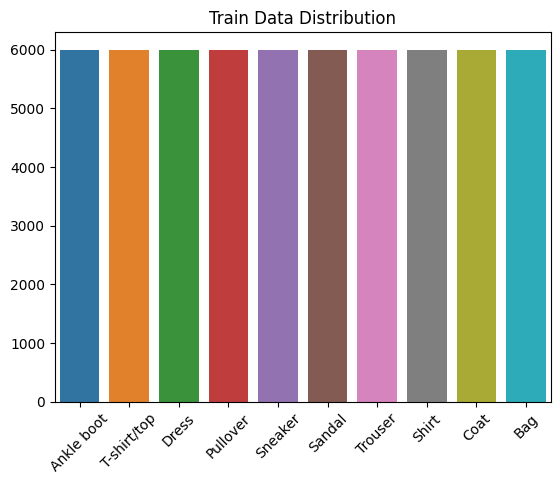


Test Data Distribution:
             samples_count_each_class
Ankle boot                       1000
Pullover                         1000
Trouser                          1000
Shirt                            1000
Coat                             1000
Sandal                           1000
Sneaker                          1000
Dress                            1000
Bag                              1000
T-shirt/top                      1000


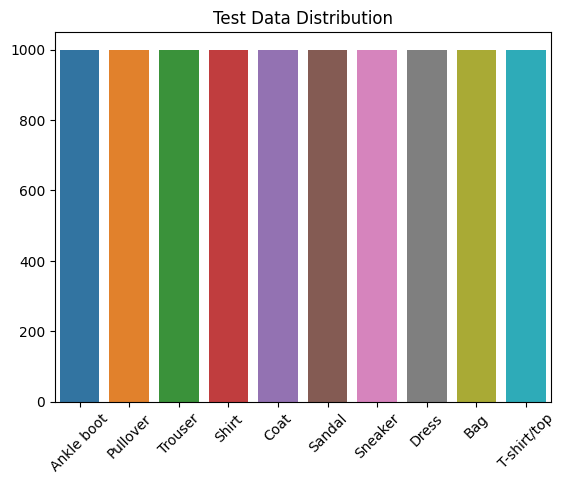




Random 15 Images from the Training Data:


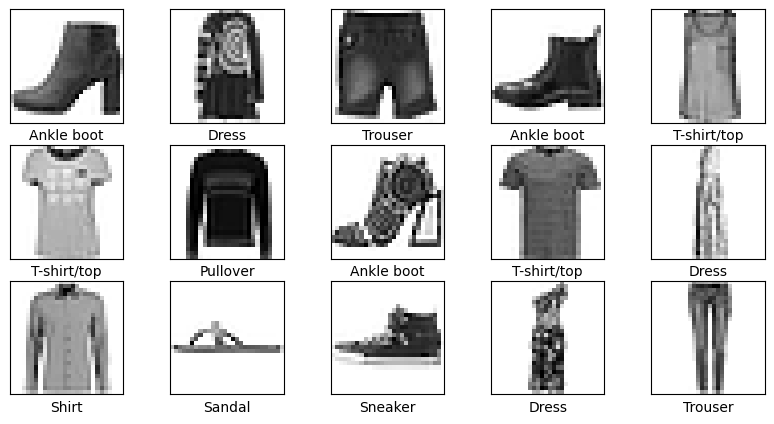




Random 10 Images from the Testing Data:


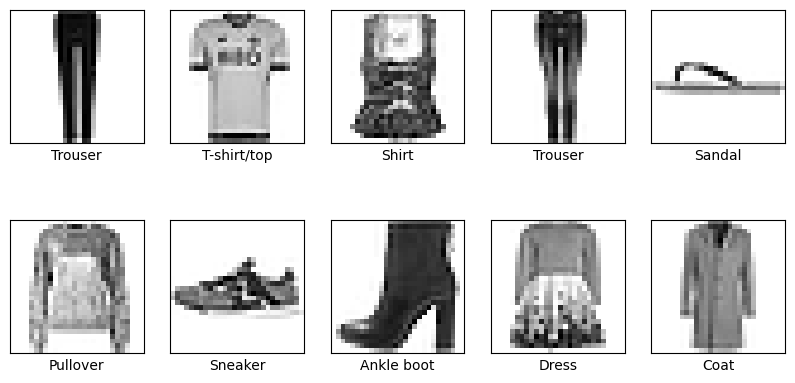

In [14]:
view_data_info()

- The data is perfectly balanced both in train and testing, hence we do not have to worry about the imbalance in the data

#### Dimensionality Reduction - PCA Method

In [15]:
train_data_flattened = train_images.reshape(train_images.shape[0], -1)
test_data_flattened = test_images.reshape(test_images.shape[0], -1)

<Axes: ylabel='Count'>

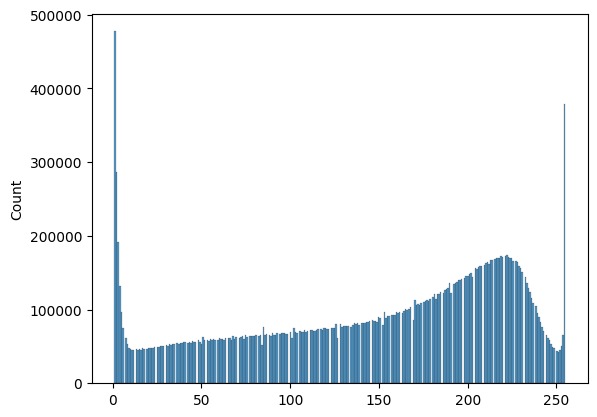

In [16]:
sns.histplot(train_data_flattened[train_data_flattened>0])

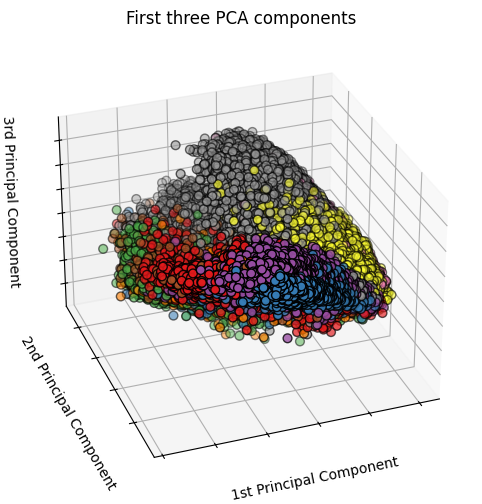


Explained Variance Ratio:  [0.29039228 0.1775531  0.06019222]
Total Explained Variance: 52.8138 %


In [17]:
get_pca_result(train_data_input= train_data_flattened)

- 52% of the complete data variance is explained by the top 3 PCA components
- Performing the PCA to understand total how many components will give total of 95% variance

In [18]:
ncomponents = get_best_first_ncomponents(train_data_flattened)

print(f"95% of variance is explained by top {ncomponents} components out of {len(train_data_flattened[0])}")
pca = PCA(n_components=ncomponents)
train_reduced = pca.fit_transform(train_data_flattened)
train_recovered = pca.inverse_transform(train_reduced)

print("reduced shape: " + str(train_reduced.shape))
print("recovered shape: " + str(train_recovered.shape))

95% of variance is explained by top 187 components out of 784
reduced shape: (60000, 187)
recovered shape: (60000, 784)



Random Training 15 Images: Actual vs Recovered

Training Data Original:


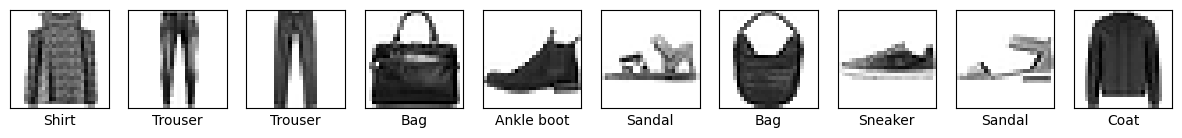


Training Data Recovered from PCA:


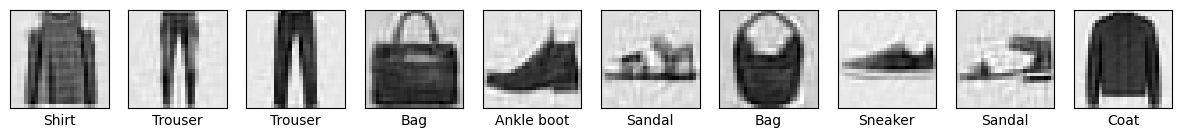

In [19]:
### check for the recovered or recreated images from the top PCA components

print("\nRandom Training 15 Images: Actual vs Recovered")

print("\nTraining Data Original:")
plt.figure(figsize=(15, 10))
total_images = 10
idx_list = []
for i in range(total_images):
    plt.subplot(1, total_images, i+1)
    rand_image_idx = np.random.randint(0, train_labels.shape[0])
    idx_list.append(rand_image_idx)
    plt.xticks([])
    plt.yticks([])
    # visualize in black and white
    plt.imshow(train_data_flattened[rand_image_idx].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[rand_image_idx]])
plt.show()

print("\nTraining Data Recovered from PCA:")
plt.figure(figsize=(15, 10))
for i in range(total_images):
    plt.subplot(1, total_images, i+1)
    rand_image_idx = idx_list[i]
    plt.xticks([])
    plt.yticks([])
    # visualize in black and white
    plt.imshow(train_recovered[rand_image_idx].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[rand_image_idx]])
plt.show()

- The images seem blurry visally, but they are recognizable for each category
- The main features and attributes of each item class are retained by reducing the total data features ~4 times

In [20]:
### use PCA fitted on train data to get the reduced test data
test_reduced = pca.transform(test_data_flattened)


#### 4. Model Development

In [21]:
def classification_results(y_actual, y_predicted):

    print("Model Accuracy: " + str(round(accuracy_score(y_actual, y_predicted)*100, 3 )), "%")
    classwise_f1 = f1_score(y_actual, y_predicted, average = 'weighted')
    print("Average F1 Score:", classwise_f1)

    plt.figure(figsize = (10,10))
    s_plt = sns.heatmap(
        pd.DataFrame(confusion_matrix(y_actual, y_predicted), columns = class_names, index = class_names),
        fmt = ".1f", annot = True)

    s_plt.set_title("Confusion Matrix");
    plt.show()

    print("Complete Classification Report")
    print(classification_report(y_actual, y_predicted, target_names = class_names))

def knn_run(train_data, train_labels, test_data, test_labels):
  knn = KNeighborsClassifier()
  knn.fit(train_data, train_labels)

  y_hat_knn = knn.predict(test_data)
  classification_results(test_labels, y_hat_knn)
  return knn

def rfc_mod(train_data, train_labels, test_data, test_labels):

  from sklearn.ensemble import RandomForestClassifier

  rfc = RandomForestClassifier(n_jobs= 4, random_state = 42)
  rfc.fit(train_data, train_labels)

  y_hat_rfc= rfc.predict(test_data)

  classification_results(test_labels, y_hat_rfc)
  return rfc

##### KNN Model

- Trying out the simplest basic model of KNN to get the best accuracy (without finetuning)

******* TEST DATA RESULTS **********
######### 1. KNN original #########
Model Accuracy: 85.54 %
Average F1 Score: 0.8546439722018904


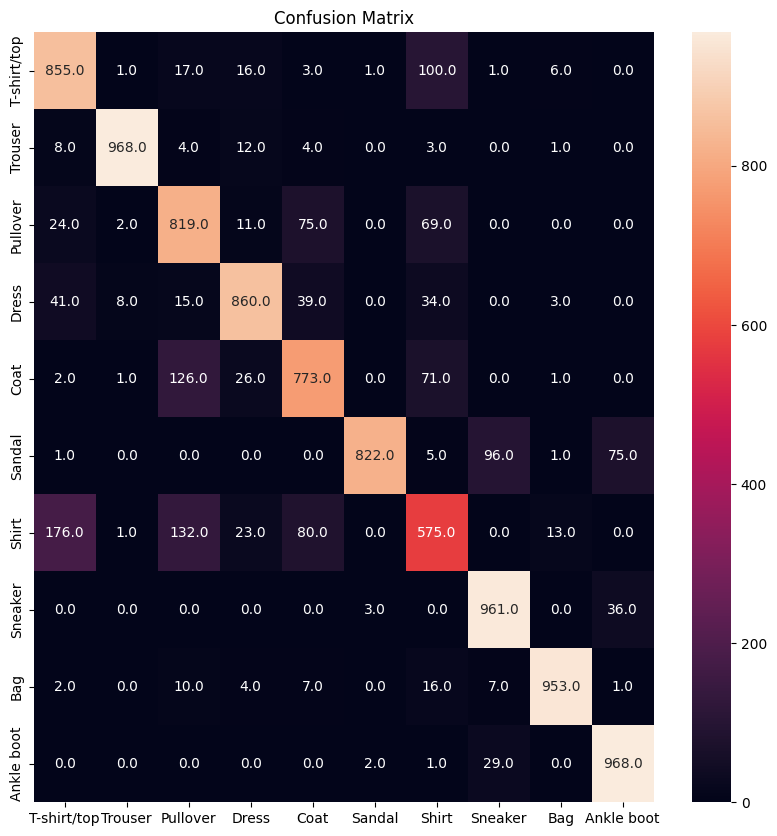

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.85      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.82      0.77      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.79      0.77      0.78      1000
      Sandal       0.99      0.82      0.90      1000
       Shirt       0.66      0.57      0.61      1000
     Sneaker       0.88      0.96      0.92      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.90      0.97      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000

######### 2. KNN PCA #########
Model Accuracy: 86.24 %
Average F1 Score: 0.861774660202013


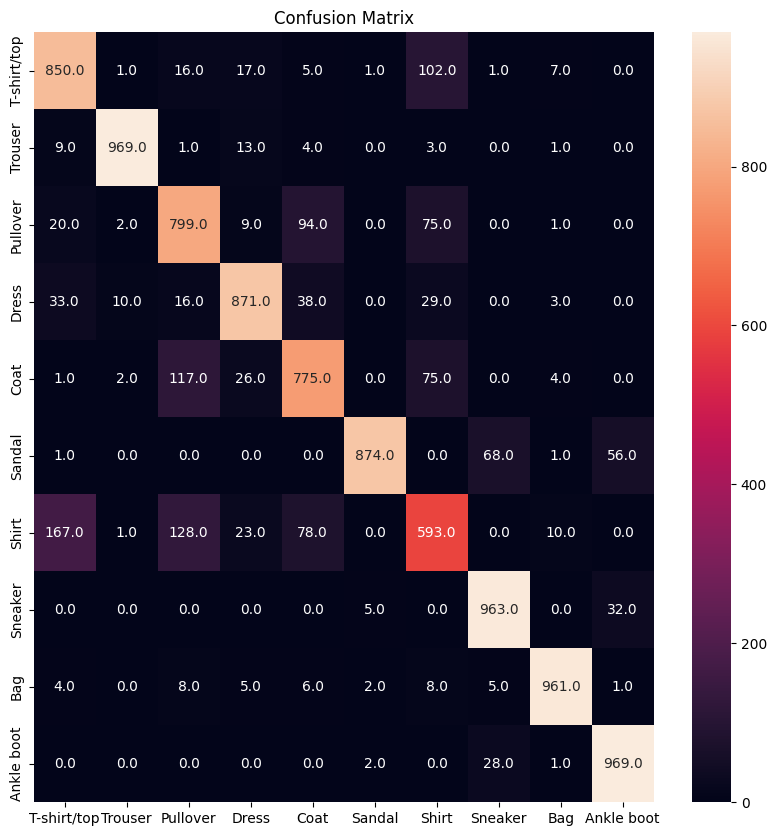

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.85      0.82      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.74      0.80      0.77      1000
       Dress       0.90      0.87      0.89      1000
        Coat       0.78      0.78      0.78      1000
      Sandal       0.99      0.87      0.93      1000
       Shirt       0.67      0.59      0.63      1000
     Sneaker       0.90      0.96      0.93      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.92      0.97      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [22]:
print("******* TEST DATA RESULTS **********")

print("######### 1. KNN original #########")
knn_original = knn_run(train_data_flattened, train_labels, test_data_flattened, test_labels)

print("######### 2. KNN PCA #########")
knn_pca = knn_run(train_reduced, train_labels, test_reduced, test_labels)

##### Decision Trees - Random Forest Classifier Model

- Trying out the simplest basic model of RFC to get the best accuracy (without finetuning)

******* TEST DATA RESULTS **********
######### 3. Random Forest original #########
Model Accuracy: 87.6 %
Average F1 Score: 0.8745025724402984


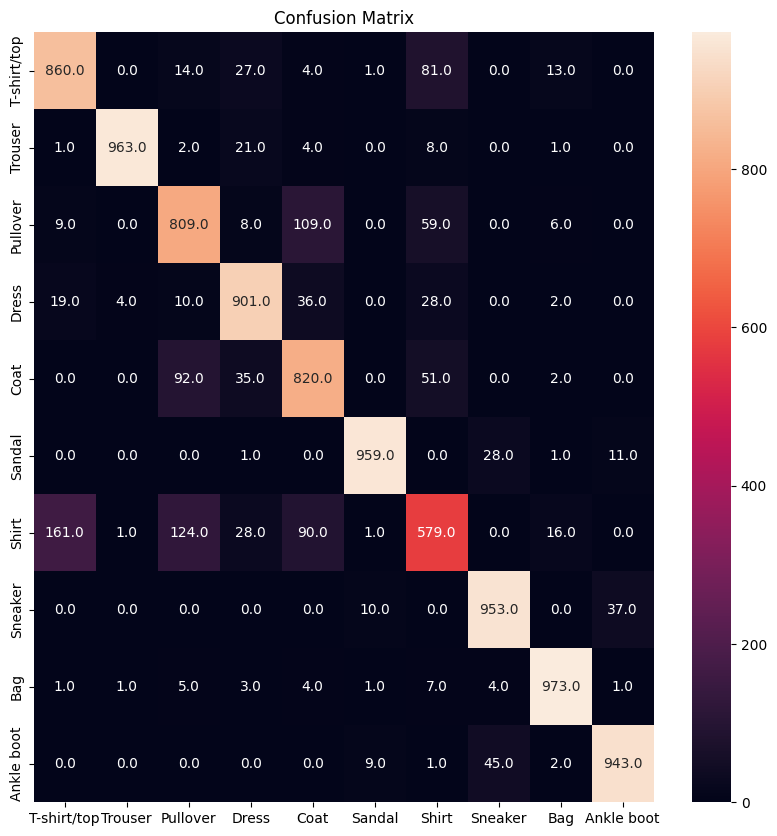

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.77      0.81      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.77      0.82      0.79      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.71      0.58      0.64      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000

######### 4. Random Forest PCA #########
Model Accuracy: 85.78 %
Average F1 Score: 0.8555327201316136


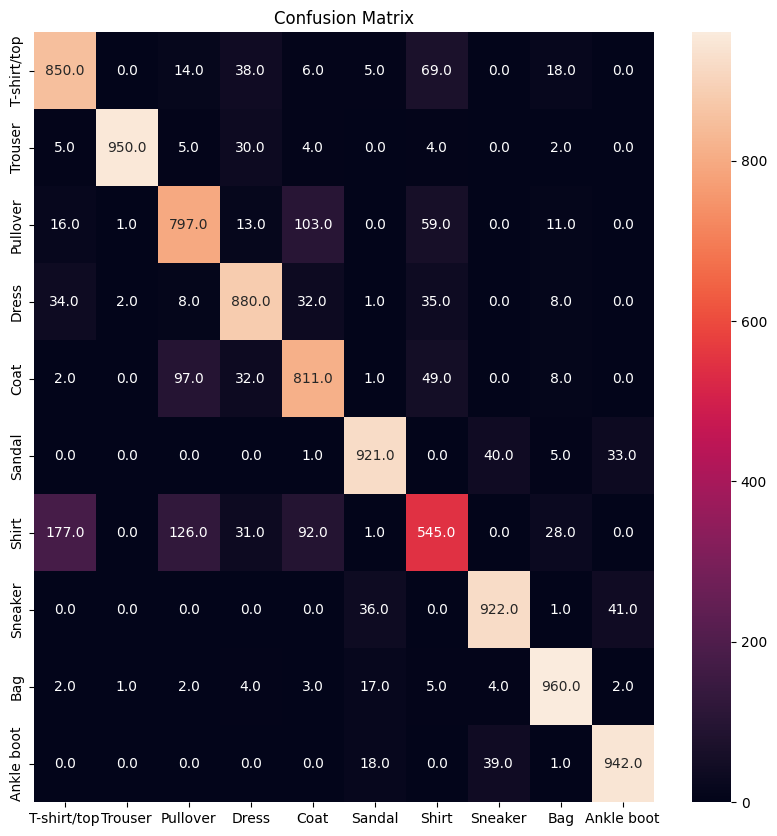

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.85      0.81      1000
     Trouser       1.00      0.95      0.97      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.77      0.81      0.79      1000
      Sandal       0.92      0.92      0.92      1000
       Shirt       0.71      0.55      0.62      1000
     Sneaker       0.92      0.92      0.92      1000
         Bag       0.92      0.96      0.94      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [23]:
print("******* TEST DATA RESULTS **********")

print("######### 3. Random Forest original #########")
rfc_original = rfc_mod(train_data_flattened, train_labels, test_data_flattened, test_labels)

print("######### 4. Random Forest PCA #########")
rfc_pca = rfc_mod(train_reduced, train_labels, test_reduced, test_labels)



##### >> Preparation for CNN Models

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split the train data to train and valid
# Valid data will be used to tune the model

generator = torch.Generator().manual_seed(28)
[train, valid] = random_split(train_set, [0.8, 0.2], generator=generator)


# Put the data in the loader
batch_size = 100

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)


In [31]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, valid_loss):

        print(f"(valid_loss {valid_loss:.4f} - train_loss {train_loss:.4f}) > self.min_delta {self.min_delta:.4f}")
        print(f"counter {self.counter}")

        if (valid_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

##### CNN - Convolutional Neural Network Model

- Trying out the simplest basic model of CNN in pytorch to get the best accuracy (without finetuning)
- The Vanilla model contains two convnets (layer1 and layer2) with 16 output channels in the first layer and 32 output channels in the 2nd layer. Outputs of 2nd convnet are flattened and sent to the FC layers 1 and 2 with 400 and 100 nodes respectively. Finally, output FC layer with 10 nodes.

In [32]:
class ModelCNN_Vanilla(nn.Module):

    def __init__(self):
        super(ModelCNN_Vanilla, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=400)
        self.drop = nn.Dropout(0.50)
        self.fc2 = nn.Linear(in_features=400, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        # out = self.drop(out)
        out = self.fc2(out)
        # out = self.drop(out)
        out = self.fc3(out)

        return out

###### Steps performed:
- Create instance of Vanilla model
- Load the model to device
- define CrossEntropyLoss, Learning Rate and Adam Optimizer

In [33]:
model = ModelCNN_Vanilla()
model.to(device)
error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

ModelCNN_Vanilla(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=400, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=400, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


###### Training 1 epoch : Model Training for the Loaded CNN Model

In [34]:
num_epochs = 1 #50
count = 0
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []
f1_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:

        outputs = model(images)
        train_loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        train_loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 40):
            with torch.no_grad():
                model.eval()

                total = 0
                correct = 0

                for images, labels in valid_loader:

                    outputs = model(images)
                    valid_loss = error(outputs, labels)

                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()

                    total += len(labels)

                accuracy = correct * 100 / total
                f1 = multiclass_f1_score(outputs, labels)
                loss_list.append(valid_loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                f1_list.append(f1)

                print(f"Iteration: {count}, Loss: {valid_loss.data:.2f}, Accuracy: {accuracy:.2f}%, F1 score: {f1:.2f}")

                model.train()

    print(f"epoch {epoch} is done")

    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop == True:
        break

Iteration: 40, Loss: 0.91, Accuracy: 74.68%, F1 score: 0.72
Iteration: 80, Loss: 0.55, Accuracy: 78.67%, F1 score: 0.79
Iteration: 120, Loss: 0.53, Accuracy: 82.34%, F1 score: 0.79
Iteration: 160, Loss: 0.51, Accuracy: 83.66%, F1 score: 0.79
Iteration: 200, Loss: 0.45, Accuracy: 84.65%, F1 score: 0.81
Iteration: 240, Loss: 0.42, Accuracy: 85.22%, F1 score: 0.81
Iteration: 280, Loss: 0.42, Accuracy: 86.56%, F1 score: 0.82
Iteration: 320, Loss: 0.39, Accuracy: 86.98%, F1 score: 0.84
Iteration: 360, Loss: 0.39, Accuracy: 87.31%, F1 score: 0.83
Iteration: 400, Loss: 0.39, Accuracy: 87.27%, F1 score: 0.85
Iteration: 440, Loss: 0.41, Accuracy: 87.45%, F1 score: 0.83
Iteration: 480, Loss: 0.45, Accuracy: 86.47%, F1 score: 0.81
epoch 0 is done
(valid_loss 0.4536 - train_loss 0.3884) > self.min_delta 0.0100
counter 0


###### Load the trained model and evaluate on test set

In [35]:
loaded_model = ModelCNN_Vanilla()
loaded_model.load_state_dict(torch.load('vanilla_model.pt', map_location = device))
loaded_model.to(device)
loaded_model.eval()
model = loaded_model

In [36]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = loaded_model(test)
        predicted = torch.max(outputs, 1)[1]
        all_predictions += list(predicted.cpu().detach().numpy())
        all_labels += list(labels.cpu().detach().numpy())
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

print('')
print('CNN Vanilla Model Accuracy is: ',sum(class_correct)*100/sum(total_correct))

Accuracy of T-shirt/Top: 88.90%
Accuracy of Trouser: 97.50%
Accuracy of Pullover: 90.90%
Accuracy of Dress: 88.10%
Accuracy of Coat: 61.60%
Accuracy of Sandal: 98.80%
Accuracy of Shirt: 63.90%
Accuracy of Sneaker: 96.10%
Accuracy of Bag: 97.70%
Accuracy of Ankle Boot: 94.00%

CNN Vanilla Model Accuracy is:  87.75


Model Accuracy: 87.75 %
Average F1 Score: 0.8760218083217993


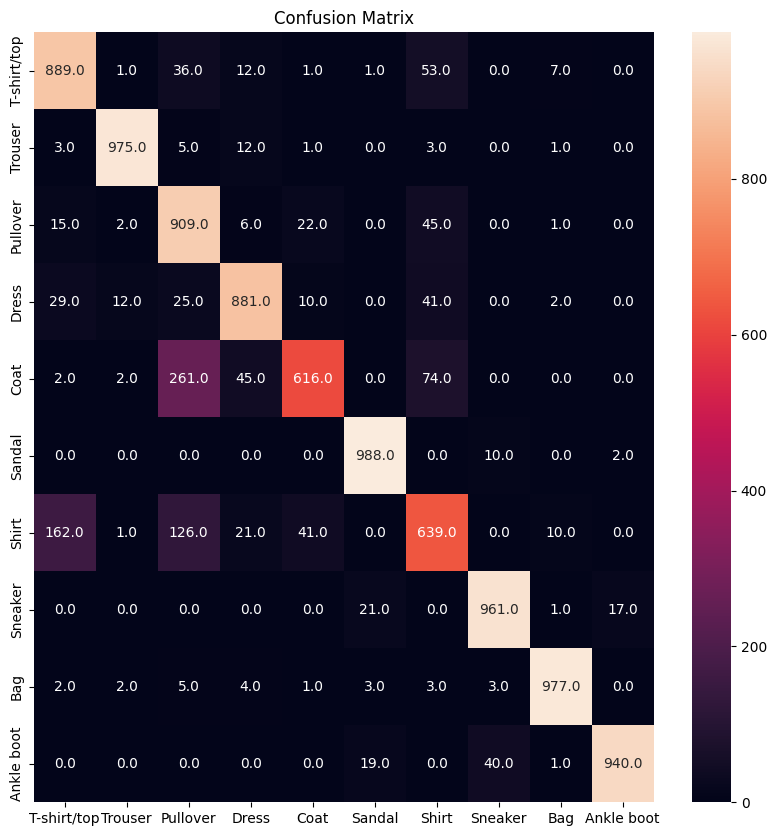

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.89      0.85      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.66      0.91      0.77      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.89      0.62      0.73      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.74      0.64      0.69      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [37]:
classification_results(all_labels,all_predictions)

### Model Selection
- Model Accuracies On Testing Dataset:
  - KNN - 85.54%
  - KNN with PCA - 86.2%
  - RF - 87.6 %
  - RF with PCA - 85.65 %
  - CNN Vanilla Model - 87.75%

- Confusion Matrix Interpretations:
  - KNN: From Confusion Matrix we can see that `T-Shirt/Top` are misclassifies/confused with `Shirt` class (talking visually - they have kind of similar features). `Shirt` class gives the lowest True Positive classification of all classes
  - RF : Even the RF Model shows lower accuracy on `Shirt` class
  - CNN: CNN is performing mis classifications for `Coat` & `Shirt` as well

- **Based on the Best Model Accuracy, CNN Model is chosen for further fine tuning process**

### Experiments on CNN Model  

#### CNN Model Training - Fine Tuned CNN Model

- SINGLE EPOCH
-  avoid overfitting, reduced number of filters in ConvNets and number of nodes in FC layer 1. Also added Dropout with probability 0.5 after FC layer 1 and FC layer 2
- To get the featuremaps from the model, function get_featuremaps() is added

In [38]:
# Build a model

class ModelCNN(nn.Module):

    def __init__(self):
        super(ModelCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=32*6*6, out_features=300)
        self.drop = nn.Dropout(0.50)
        self.fc2 = nn.Linear(in_features=300, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

    def get_featuremaps(self,x):
        feat_layer1 = self.layer1(x)
        feat_layer2 = self.layer2(feat_layer1)
        flattened = feat_layer2.view(feat_layer2.size(0),-1)
        feat_fc1 = self.fc1(flattened)
        # feat_fc1 = self.drop(feat_fc1)
        feat_fc2 = self.fc2(feat_fc1)
        # feat_fc2 = self.drop(feat_fc2)
        feat_fc3 = self.fc3(feat_fc2)
        feat_conv1 = self.layer1[0](x)
        feat_conv2 = self.layer2[0](feat_layer1)

        return {'feat_conv1':feat_conv1,
                'feat_conv2':feat_conv2,
                'feat_layer1':feat_layer1,
                'feat_layer2':feat_layer2,
                'feat_fc1':feat_fc1,
                'feat_fc2':feat_fc2,
                'feat_fc3':feat_fc3}

In [39]:
model = ModelCNN()
model.to(device)
error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

ModelCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [40]:
num_epochs = 1#50
count = 0
early_stopping = EarlyStopping(tolerance=3, min_delta=0.01)

# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []
f1_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        train_loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        train_loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 40):
            with torch.no_grad():
                model.eval()

                total = 0
                correct = 0

                for images, labels in valid_loader:

                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    valid_loss = error(outputs, labels)

                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()

                    total += len(labels)

                accuracy = correct * 100 / total
                f1 = multiclass_f1_score(outputs, labels)
                loss_list.append(valid_loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                f1_list.append(f1)

                print(f"Iteration: {count}, Loss: {valid_loss.data:.2f}, Accuracy: {accuracy:.2f}%, F1 score: {f1:.2f}")

                model.train()

    print(f"epoch {epoch} is done")

    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop == True:
        break

Iteration: 40, Loss: 1.46, Accuracy: 68.62%, F1 score: 0.74
Iteration: 80, Loss: 0.84, Accuracy: 74.95%, F1 score: 0.72
Iteration: 120, Loss: 0.69, Accuracy: 76.31%, F1 score: 0.78
Iteration: 160, Loss: 0.62, Accuracy: 77.90%, F1 score: 0.77
Iteration: 200, Loss: 0.58, Accuracy: 78.71%, F1 score: 0.79
Iteration: 240, Loss: 0.56, Accuracy: 80.11%, F1 score: 0.77
Iteration: 280, Loss: 0.52, Accuracy: 81.47%, F1 score: 0.80
Iteration: 320, Loss: 0.50, Accuracy: 81.61%, F1 score: 0.82
Iteration: 360, Loss: 0.47, Accuracy: 82.63%, F1 score: 0.82
Iteration: 400, Loss: 0.48, Accuracy: 83.23%, F1 score: 0.80
Iteration: 440, Loss: 0.47, Accuracy: 83.18%, F1 score: 0.83
Iteration: 480, Loss: 0.45, Accuracy: 83.70%, F1 score: 0.82
epoch 0 is done
(valid_loss 0.4485 - train_loss 0.5494) > self.min_delta 0.0100
counter 0


####Loading the trained model and evaluating on test dataset

In [41]:
loaded_model = ModelCNN()
loaded_model.load_state_dict(torch.load('finetuned_model.pt', map_location = device))
loaded_model.to(device)
loaded_model.eval()
model = loaded_model

Model Accuracy ->

In [42]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = loaded_model(test)
        predicted = torch.max(outputs, 1)[1]
        all_predictions += list(predicted.cpu().detach().numpy())
        all_labels += list(labels.cpu().detach().numpy())
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

print('')
print('CNN Finetuned Model Accuracy is: ',sum(class_correct)*100/sum(total_correct))

Accuracy of T-shirt/Top: 77.60%
Accuracy of Trouser: 97.30%
Accuracy of Pullover: 82.90%
Accuracy of Dress: 89.10%
Accuracy of Coat: 80.40%
Accuracy of Sandal: 98.20%
Accuracy of Shirt: 80.10%
Accuracy of Sneaker: 95.00%
Accuracy of Bag: 97.30%
Accuracy of Ankle Boot: 95.60%

CNN Finetuned Model Accuracy is:  89.35


Model Accuracy: 89.35 %
Average F1 Score: 0.8952750632567819


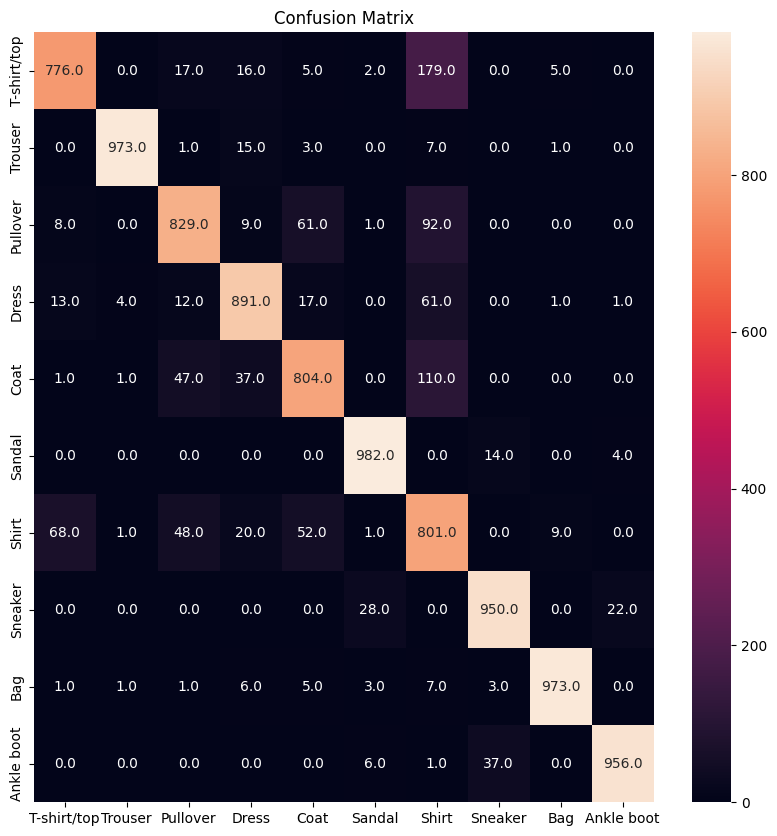

Complete Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.78      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.87      0.83      0.85      1000
       Dress       0.90      0.89      0.89      1000
        Coat       0.85      0.80      0.83      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.64      0.80      0.71      1000
     Sneaker       0.95      0.95      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.89      0.90     10000



In [43]:
classification_results(all_labels,all_predictions)

In [44]:
## commented the model saving process
# torch.save(model.state_dict(), 'model_latest.pt')

#### CNN Model Visualizations and Interpretability

 - Getting the CNN featuremaps and layer weights from the trained model on test images and visualized them

In [45]:
loaded_model = ModelCNN()
loaded_model.load_state_dict(torch.load('finetuned_model.pt', map_location = device))
loaded_model.to(device)
loaded_model.eval()

ModelCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=300, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [46]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = loaded_model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

print('')
print('Overall Accuracy of the model on test data: ',sum(class_correct)*100/sum(total_correct))

Accuracy of T-shirt/Top: 77.60%
Accuracy of Trouser: 97.30%
Accuracy of Pullover: 82.90%
Accuracy of Dress: 89.10%
Accuracy of Coat: 80.40%
Accuracy of Sandal: 98.20%
Accuracy of Shirt: 80.10%
Accuracy of Sneaker: 95.00%
Accuracy of Bag: 97.30%
Accuracy of Ankle Boot: 95.60%

Overall Accuracy of the model on test data:  89.35


In [47]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = loaded_model(test)

        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

#### Sample Input Image for which the features are visualized

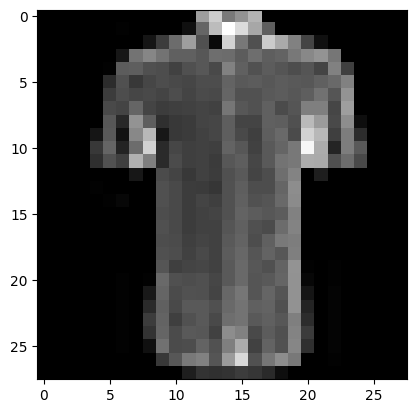

In [48]:
image = images[0,0,:,:]
plt.imshow(image, cmap = 'gray')
# plt.savefig('input_image_shirt.jpg', bbox_inches='tight')
plt.show()

In [49]:
features = loaded_model.get_featuremaps(images)

In [50]:
for key in features.keys():
    features[key] = features[key].cpu().detach().numpy()
    print(key,features[key].shape)

feat_conv1 (100, 16, 28, 28)
feat_conv2 (100, 32, 12, 12)
feat_layer1 (100, 16, 14, 14)
feat_layer2 (100, 32, 6, 6)
feat_fc1 (100, 300)
feat_fc2 (100, 100)
feat_fc3 (100, 10)


####Plotting featuremaps from the conv layers and convnet layers
- (conv + batchnorm + ReLu + Maxpool)

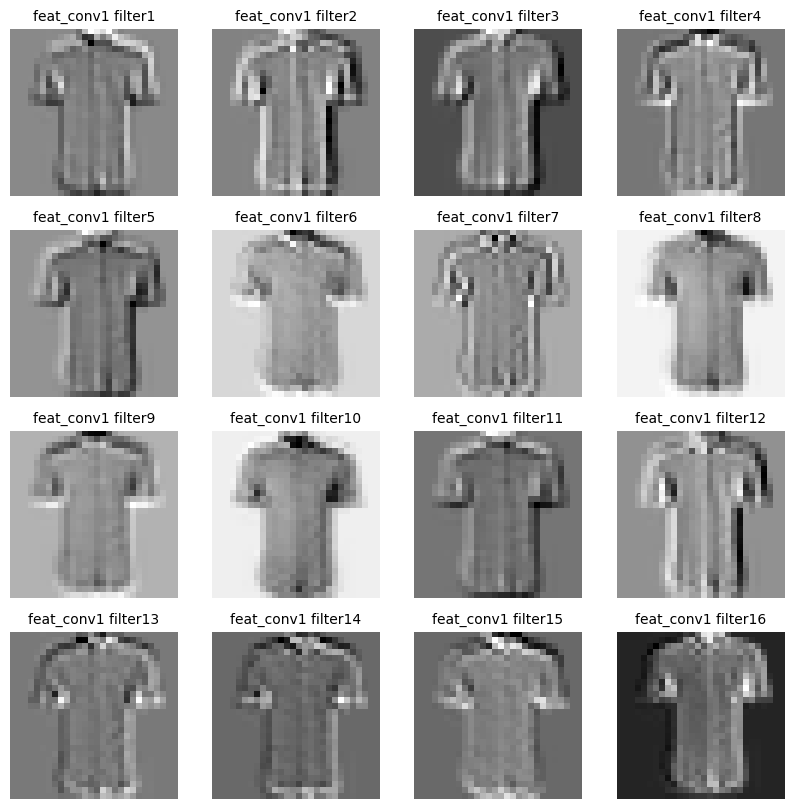

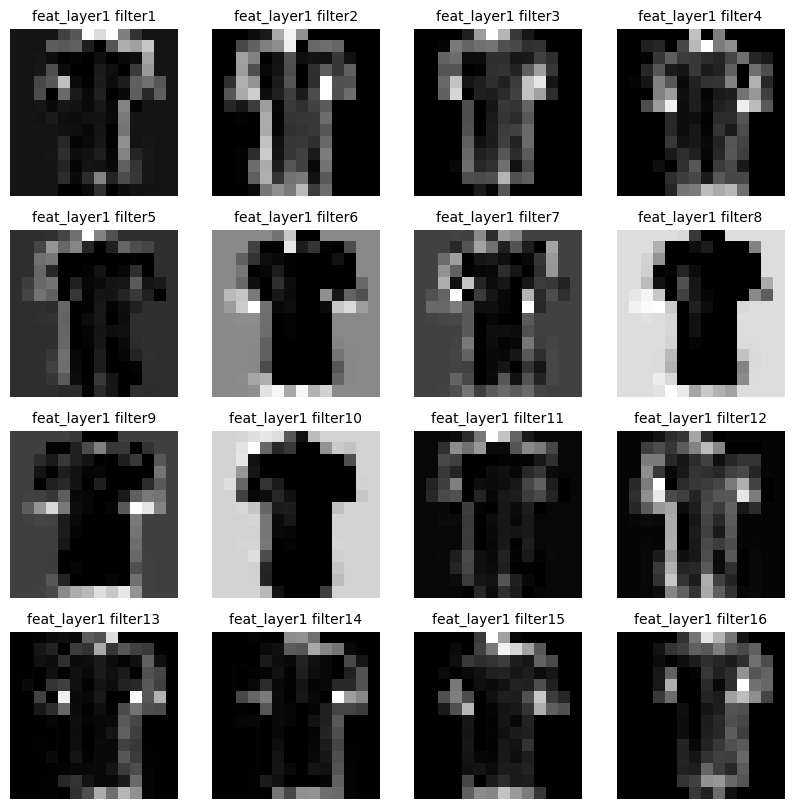

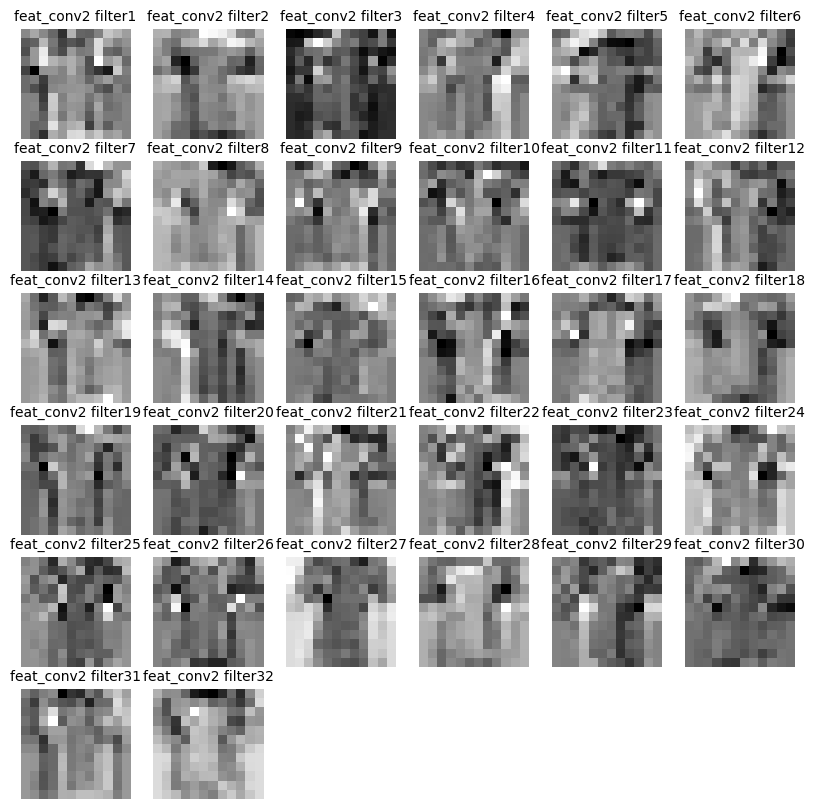

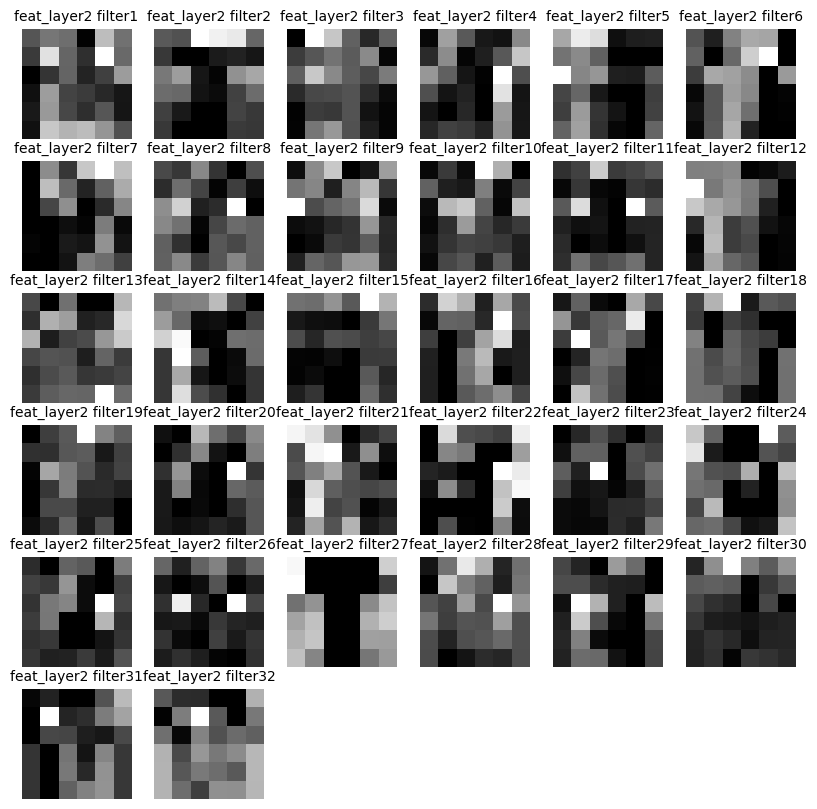

In [51]:
keys = ['feat_conv1','feat_layer1','feat_conv2','feat_layer2']

for key in keys:
  feat = features[key][0,:,:,:]

  fig = plt.figure(figsize=(10, 10))
  for i in range(feat.shape[0]):
      g = int(np.ceil(np.sqrt(feat.shape[0])))
      a = fig.add_subplot(g, g, i+1)
      imgplot = plt.imshow(feat[i,:,:], cmap = 'gray')
      a.axis("off")
      a.set_title(key+' filter'+str(i+1), fontsize=10)
  # plt.title('feature map of the layer: '+key)
  # plt.savefig(str(key+'.jpg'), bbox_inches='tight')
  plt.show()

####Plotting features from FC layers
- FC Layers 1, 2, and 3 for the first 10 test images

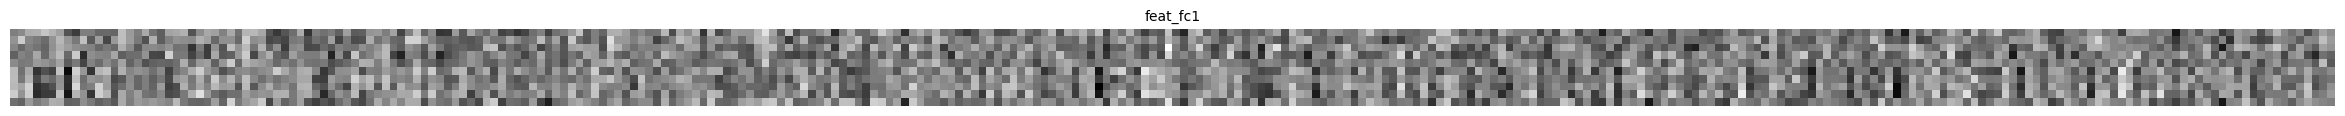

In [52]:
keys = ['feat_fc1','feat_fc2','feat_fc3']

key = keys[0]
feat = features[key][:10,:]
feat = (feat - feat.min())/(feat.max() - feat.min())
fig = plt.figure(figsize = (30,30))
plt.imshow(feat, cmap = 'gray')
plt.axis("off")
plt.title(key, fontsize=10)
# plt.savefig(str(key+'_first10images.jpg'), bbox_inches='tight')
plt.show()

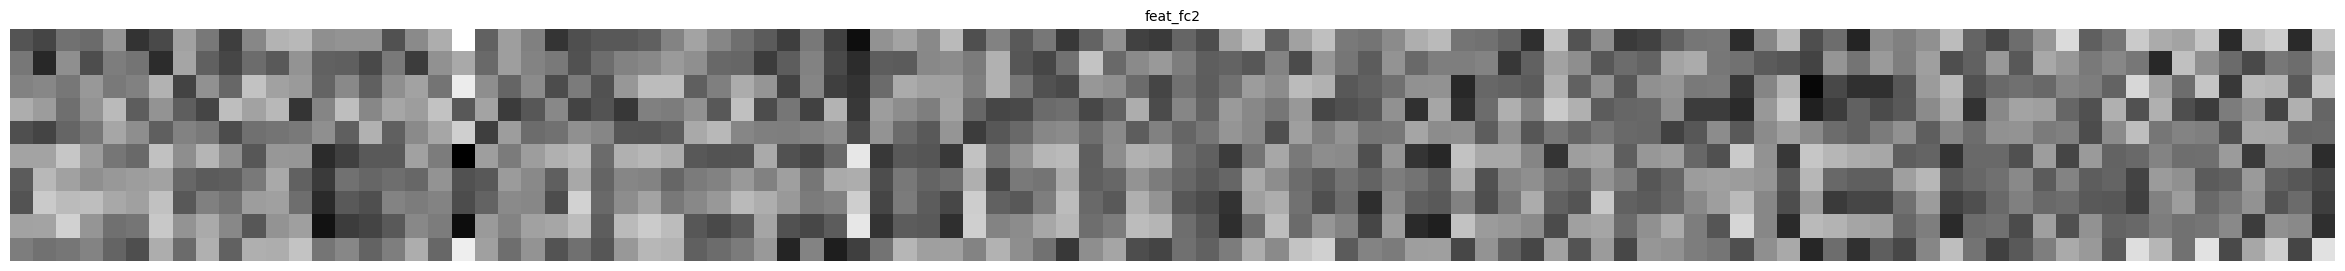

In [53]:
key = keys[1]
feat = features[key][:10,:]
feat = (feat - feat.min())/(feat.max() - feat.min())
fig = plt.figure(figsize = (30,30))
plt.imshow(feat, cmap = 'gray')
plt.axis("off")
plt.title(key, fontsize=10)
# plt.savefig(str(key+'_first10images.jpg'), bbox_inches='tight')
plt.show()

Ground truth labels for the features shown below are:  tensor([6, 3, 0, 8, 6, 7, 5, 5, 7, 0])


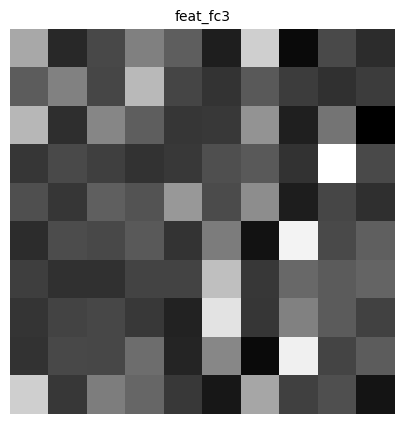

In [54]:
print('Ground truth labels for the features shown below are: ',labels[:10])
key = keys[2]
feat = features[key][:10,:]
feat = (feat - feat.min())/(feat.max() - feat.min())
fig = plt.figure(figsize = (5,5))
plt.imshow(feat, cmap = 'gray')
plt.axis("off")
plt.title(key, fontsize=10)
# plt.savefig(str(key+'_first10images.jpg'), bbox_inches='tight')
plt.show()

#### Visualizing weights
 - Obtaining weights from the trained model and converting to numpy arrays after shifting them to cpu from the device

In [55]:
weights = {}
weights['conv1'] = loaded_model.layer1[0].weight.cpu().detach().numpy()
weights['conv2'] = loaded_model.layer2[0].weight.cpu().detach().numpy()
weights['fc1'] = loaded_model.fc1.weight.cpu().detach().numpy()
weights['fc2'] = loaded_model.fc2.weight.cpu().detach().numpy()
weights['fc3'] = loaded_model.fc3.weight.cpu().detach().numpy()

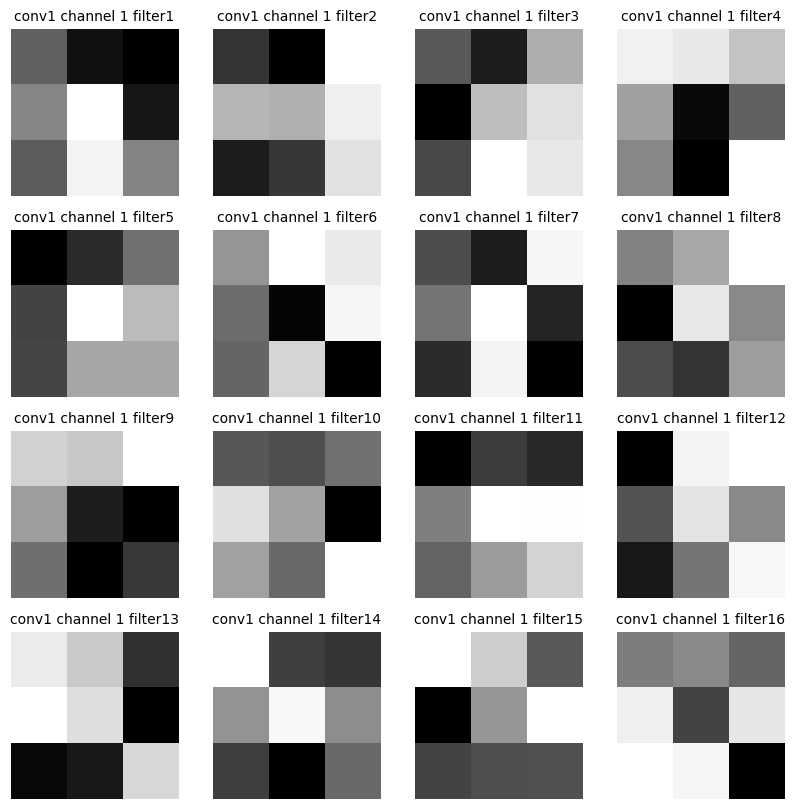

In [56]:
#conv1 weight visualization
key = 'conv1'
conv_weights = weights[key]
conv_weights = (conv_weights - conv_weights.min())/(conv_weights.max() - conv_weights.min())
n_filters = conv_weights.shape[0]
fig = plt.figure(figsize=(10, 10))
for i in range(n_filters):
    filter = conv_weights[i,0,:,:]
    ax = plt.subplot(4, 4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    imagplot = plt.imshow(filter,cmap = 'gray')
    ax.axis("off")
    ax.set_title(key+' channel 1'+' filter'+str(i+1), fontsize=10)
# plt.savefig('conv1_weights.jpg', bbox_inches='tight')
plt.show()

### Conclusions of the exercise:
- The final tuned model accuracy is 89.35%
- Visualization and Interpretability: All the weights, feature maps and corresponding activations in Convolution and Fully Connected Layers are viewed. (details the report)

##END

**REFERENCES**
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction
- https://medium.datadriveninvestor.com/k-nearest-neighbor-classification-with-python-numpy-tensorflow-on-fashion-mnist-dataset-d8361187c09c
- https://www.baeldung.com/cs/multi-class-f1-score

